# Interpreting Intent via CPTs — Explainer

This section demonstrates **how CPTs support interpretability**:

- **Uncertainty reduction:** Use **Mutual Information (MI)** to show how each feature reduces uncertainty about intent.
- **Sensitivity Analysis:** See how changing a single attribute affects predicted intent probability.
- **Marginal Effects:** Quantify average impact of having vs. not having an attribute.
- **Network Structure Dependencies:** Visualize which variables directly affect `intent` (and independencies implied by missing edges).

## Imports and inputs (reusing earlier cells)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths (edit if needed)
CPT_LONG_PATH = Path('bn_out/intent_cpt_long.csv')
CPT_WIDE_PATH = Path('bn_out/intent_cpt_wide.csv')
VAL_PRED_PATH = Path('bn_out/val_predictions.csv')

cpt_long = pd.read_csv(CPT_LONG_PATH)
val_pred = pd.read_csv(VAL_PRED_PATH)

# Identify parent columns (exclude intent_state and prob; drop helper columns like 'intent' if present)
all_cols = cpt_long.columns.tolist()
parent_cols = [c for c in all_cols if c not in ('intent_state', 'prob')]
parent_cols = [c for c in parent_cols if c != 'intent']

# Keep only P(intent=1 | parents)
cpt_long['intent_state'] = cpt_long['intent_state'].astype(str)
p1 = cpt_long[cpt_long['intent_state'].isin(['1','1.0'])].copy()
if p1.empty:
    p1 = cpt_long[cpt_long['intent_state'] == 1].copy()
p1 = p1.rename(columns={'prob': 'p_intent_1'}).drop(columns=['intent_state'])

overall_p1 = p1['p_intent_1'].mean()
print('Detected parent columns:', parent_cols)
print('Overall mean P(intent=1) from CPT (uniform prior):', round(float(overall_p1), 4))

Detected parent columns: ['added_to_cart', 'applied_filters', 'device', 'prior_purchaser', 'reached_checkout', 'traffic_source', 'used_search']
Overall mean P(intent=1) from CPT (uniform prior): 0.4591


## 1) Mutual Information — How features reduce uncertainty

,feature,MI_bits
0,prior_purchaser,6.891338e-03
1,traffic_source,2.288678e-03
2,added_to_cart,1.649811e-03
3,reached_checkout,3.796916e-04
4,device,2.876473e-04
5,used_search,3.485730e-05
6,applied_filters,2.410896e-07


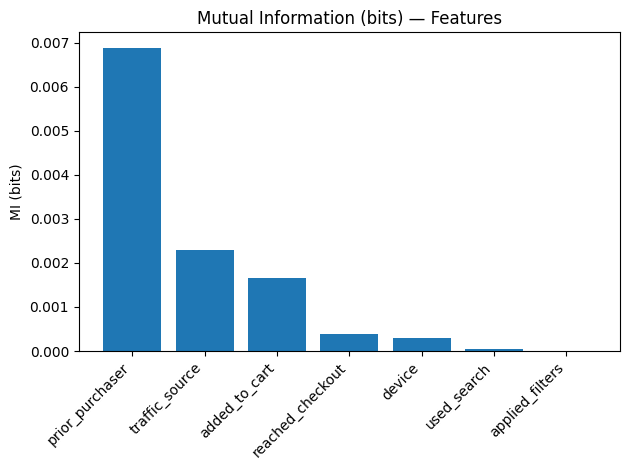

In [2]:
def mi_from_cpt_for_feature(df, feature, parent_cols):
    # Uniform over parent configs
    p1_by_f = df.groupby(feature)['p_intent_1'].mean()
    counts = df.groupby(feature, as_index=False).size()
    total = float(counts['size'].sum())
    p_f = (counts.set_index(feature)['size'] / total).reindex(p1_by_f.index)
    p_i1_f = (p_f * p1_by_f)
    p_i0_f = (p_f * (1.0 - p1_by_f))
    p_i1 = float(p_i1_f.sum())
    p_i0 = float(p_i0_f.sum())
    mi = 0.0
    for f_state in p_f.index:
        for p_if, p_i in [(p_i0_f.get(f_state, 0.0), p_i0), (p_i1_f.get(f_state, 0.0), p_i1)]:
            if p_if > 0 and p_f[f_state] > 0 and p_i > 0:
                mi += p_if * np.log(p_if / (p_i * p_f[f_state]))
    return mi / np.log(2.0), p1_by_f.to_dict()

mi_rows = []
state_expectations = {}
for feat in parent_cols:
    mi_bits, mapping = mi_from_cpt_for_feature(p1, feat, parent_cols)
    mi_rows.append({'feature': feat, 'MI_bits': mi_bits})
    state_expectations[feat] = mapping
mi_df = pd.DataFrame(mi_rows).sort_values('MI_bits', ascending=False).reset_index(drop=True)
display(mi_df)

# Plot MI (matplotlib, single plot, no custom colors)
plt.figure()
plt.bar(mi_df['feature'], mi_df['MI_bits'])
plt.title('Mutual Information (bits) — Features')
plt.xticks(rotation=45, ha='right')
plt.ylabel('MI (bits)')
plt.tight_layout()
plt.show()

## 2) Sensitivity Analysis — How changing an attribute shifts intent probability

Example feature for sensitivity: prior_purchaser


,state,expected_p_intent_1,delta_vs_overall
0,1,0.507753,0.048667
1,0,0.410419,-0.048667


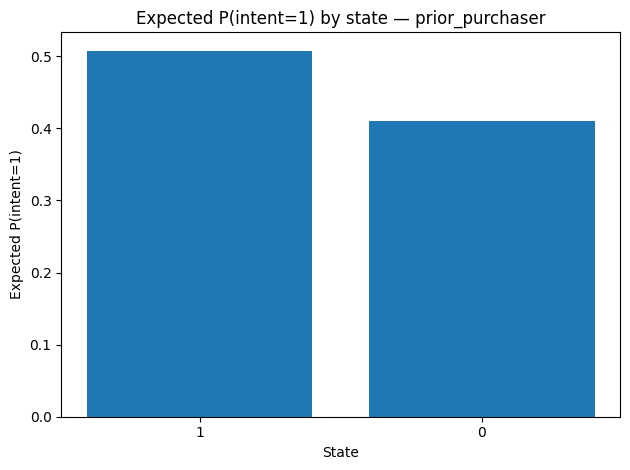

In [3]:
def sensitivity_table(feature, mapping_dict, overall_p1):
    rows = []
    for s, p1_state in mapping_dict[feature].items():
        rows.append({'state': str(s), 'expected_p_intent_1': float(p1_state),
                     'delta_vs_overall': float(p1_state - overall_p1)})
    df_feat = pd.DataFrame(rows).sort_values('expected_p_intent_1', ascending=False).reset_index(drop=True)
    return df_feat

# Choose a feature (top MI or first parent)
example_feature = mi_df.iloc[0]['feature'] if not mi_df.empty else (parent_cols[0] if parent_cols else None)
print('Example feature for sensitivity:', example_feature)

if example_feature is not None:
    sens_df = sensitivity_table(example_feature, state_expectations, overall_p1)
    display(sens_df)
    # Bar plot of expected P(intent=1) by state
    plt.figure()
    plt.bar(sens_df['state'], sens_df['expected_p_intent_1'])
    plt.title(f'Expected P(intent=1) by state — {example_feature}')
    plt.xlabel('State')
    plt.ylabel('Expected P(intent=1)')
    plt.tight_layout()
    plt.show()

## 3) Marginal Effects — Average impact of having vs. not having an attribute

,feature,state,expected_p_intent_1,marginal_effect_vs_overall
0,added_to_cart,0,0.435259,-0.023827
1,added_to_cart,1,0.482913,0.023827
2,applied_filters,0,0.458798,-0.000288
3,applied_filters,1,0.459374,0.000288
4,device,desktop,0.449135,-0.009951
5,device,mobile,0.469037,0.009951
6,prior_purchaser,0,0.410419,-0.048667
7,prior_purchaser,1,0.507753,0.048667
8,reached_checkout,0,0.470518,0.011432
9,reached_checkout,1,0.447654,-0.011432


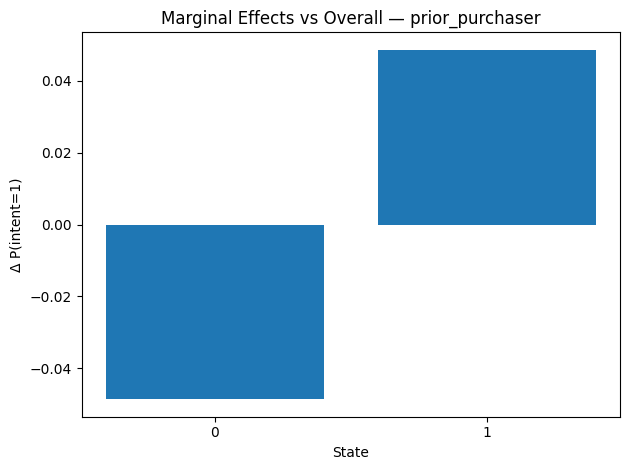

In [4]:
rows = []
for feat, mapping in state_expectations.items():
    for state, p1_state in mapping.items():
        rows.append({'feature': feat,
                     'state': str(state),
                     'expected_p_intent_1': float(p1_state),
                     'marginal_effect_vs_overall': float(p1_state - overall_p1)})
me_df = pd.DataFrame(rows).sort_values(['feature','state']).reset_index(drop=True)
display(me_df.head(30))

# Optionally, plot marginal effects for the example feature
if example_feature is not None:
    sub = me_df[me_df['feature'] == example_feature]
    plt.figure()
    plt.bar(sub['state'], sub['marginal_effect_vs_overall'])
    plt.title(f'Marginal Effects vs Overall — {example_feature}')
    plt.xlabel('State')
    plt.ylabel('Δ P(intent=1)')
    plt.tight_layout()
    plt.show()

## 4) Network Structure Dependencies — Parents of `intent`

Direct parents (from CPT): ['added_to_cart', 'applied_filters', 'device', 'prior_purchaser', 'reached_checkout', 'traffic_source', 'used_search']


C:\Users\mebub_9a7jdi8\AppData\Local\Temp\ipykernel_11564\1532644411.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


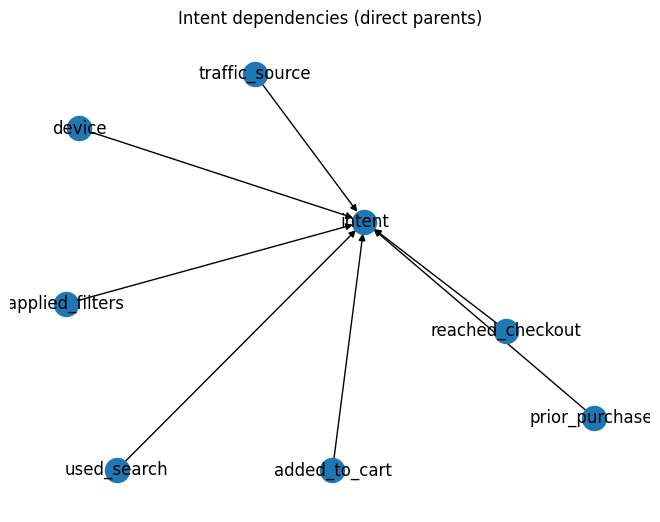

In [5]:
# From the CPT alone, we can recover the direct parents of 'intent' (the columns in the CPT).
print('Direct parents (from CPT):', parent_cols)

# Optional: try to draw a small graph intent <- parents (needs networkx, silently skip if unavailable)
try:
    import networkx as nx
    import matplotlib.pyplot as plt
    G = nx.DiGraph()
    G.add_node('intent')
    for p in parent_cols:
        G.add_edge(p, 'intent')
    plt.figure()
    pos = nx.spring_layout(G, seed=0)
    nx.draw(G, pos, with_labels=True, arrows=True)
    plt.title('Intent dependencies (direct parents)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Graph drawing skipped (networkx not installed or plotting failed).')